In [9]:
%load_ext autoreload
%autoreload 2
from funman_demo.example.demo120822 import Scenario1, Scenario2
from IPython.display import Markdown as md

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notes
- Focus on data products
    - parameter space
    - quality
    - query
- Edit models to make comparable
    - Add measurements
    - parameter overlap

# Scenario 1
0. No Intervention
1. Intervene at day 1, 0.05 reduction in transmissibility
2. Intervene at day 30, X reduction in transmissibility


In [10]:
# Scenario 1 models
scenario1 = Scenario1()
# scenario1.to_md(scenario1.models["intervention1"]["SIR+H"]) 
scenario1.to_md(scenario1.models["intervention1"]["SVIIR"])

# Bilayer and Measurement Model
SIR Bilayer (left), Hospitalized Measurement (right)

![](bilayer.png) ![](measurement.png)
# Initial State (population 10000)
- ## I: 1
- ## I_v: 1
- ## V: 1
- ## R: 1
- ## S: 10000
# Parameter Bounds
- ## v_r: [0.05, 0.05]
- ## v_s2: [6.7e-05, 6.7e-05]
- ## gamma_2: [0.07142857142857142, 0.07142857142857142]
- ## gamma_1: [0.07142857142857142, 0.07142857142857142]
- ## hr_2: [0.01, 0.01]
- ## beta_2: [6.7e-05, 6.7e-05]
- ## hr_1: [0.01, 0.01]
- ## v_s1: [6.7e-05, 6.7e-05]
- ## beta_1: [6.7e-05, 6.7e-05]
# Scenario Configuration
- ## step_size: 1
- ## query_variable: H
- ## query_threshold: 10000
- ## duration: 1
# Query
- ## $\bigwedge\limits_{t \in [0,1]} H_t \leq10000$


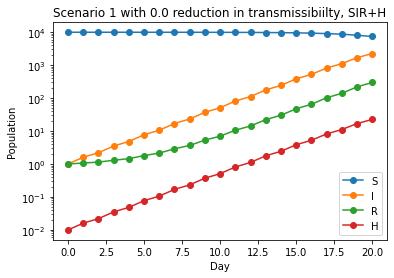

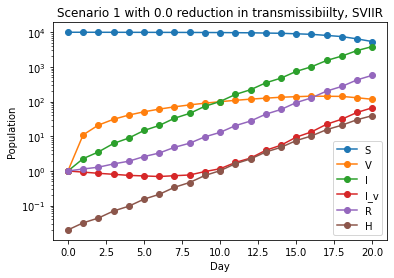

SIR+H: Query Satisfied
SVIIR: Query Satisfied


In [14]:
# 0. No intervention. Will H_t <= 50 forall t?

# H = hr(I_v + I)

duration = 20
step_size = 2
hospital_capacity=1000

scenario1 = Scenario1(duration=duration, query_threshold=None, step_size=step_size)
transmissibility_reduction = 0.0
# results = scenario1.analyze_intervention_1(transmissibility_reduction, models=["SIR+H", "SVIIR"])
results = scenario1.analyze_intervention_1(transmissibility_reduction, models=["SIR+H", "SVIIR"])

print("\n".join([r["message"] for n, r in results.items()]))
#scenario1.compare_model_results(results)

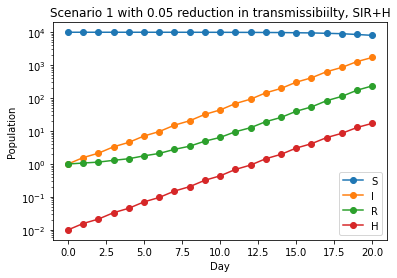

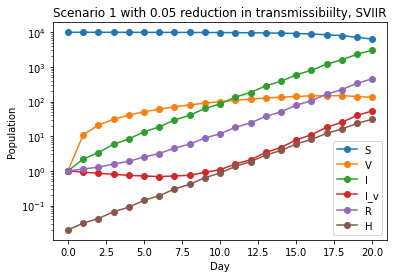

SIR+H: Query Satisfied
SVIIR: Query Satisfied


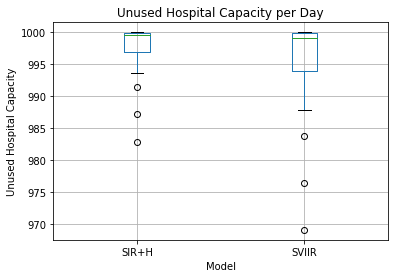

In [16]:
# 1. Intervene with 0.05 reduction in transmissibility.  Will H_t <= 50 forall t?

transmissibility_reduction = 0.05
scenario1 = Scenario1(duration=duration, query_threshold=hospital_capacity, step_size=step_size)
results = scenario1.analyze_intervention_1(transmissibility_reduction, models=["SIR+H", "SVIIR"])

print("\n".join([r["message"] for n, r in results.items()]))
scenario1.compare_model_results(results)

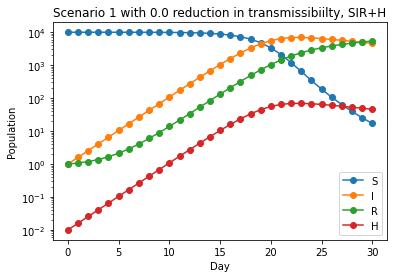

In [ ]:
# What is S, I, and R at day 30, with no intervervention
start_day = 30
scenario1 = Scenario1(duration=start_day, step_size=1, query_threshold=None)
transmissibility_reduction = 0.0
results = scenario1.analyze_intervention_1(transmissibility_reduction, models=["SIR+H", "SVIIR"])
# print(results["SIR+H"])
day30 = results["SIR+H"]["dataframe"].loc[start_day]
day30

In [19]:
#day30 = results["SIR+H"]["dataframe"].rename(lambda x: f"SIR+H_{x}").merge(results["SVIIR"]["dataframe"].rename(lambda x: f"SVIIR_{x}"))
results

{'SIR+H': {'message': 'SIR+H: Query Not Satisfied',
  'plot': None,
  'dataframe': None},
 'SVIIR': {'message': 'SVIIR: Query Not Satisfied',
  'plot': None,
  'dataframe': None}}

Starting initializing dynamics of model
Initialized dynamics of model
Checking true query
--- False(dict_values([[6.03e-05, 7.035e-05]]))


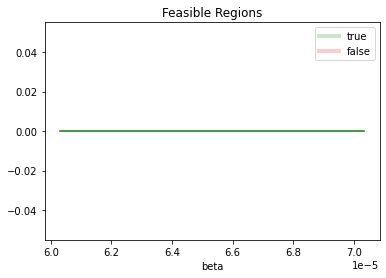

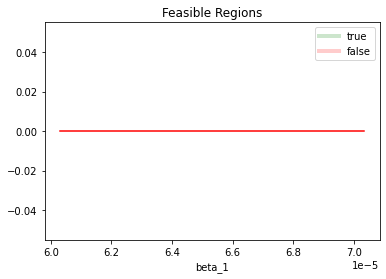

In [28]:
# Intervention 2 is over a shorter time period, with different initial conditions
# The task is to find the level of efficacy beta needed to satisfy the query
hospital_capacity = 50
scenario1 = Scenario1(duration=10, query_threshold=hospital_capacity, step_size=2)
init_values={"S": day30["S"], "I": day30["I"], "R": day30["R"]}
results = scenario1.analyze_intervention_2([-0.05, 0.1], models=["SIR+H", "SVIIR"])


In [34]:
results["SIR+H"].true_point_timeseries(points=[
    {"values": {"beta": 0.1}}
])

[    index         H            S          I         R      beta     gamma  \
 0       0  0.010000  9998.000000   1.000000  1.000000  0.000065  0.071429   
 1       1  0.015817  9997.346881   1.581691  1.071429  0.000065  0.071429   
 2       2  0.021634  9996.693761   2.163382  1.142857  0.000065  0.071429   
 3       3  0.034216  9995.281000   3.421616  1.297384  0.000065  0.071429   
 4       4  0.046799  9993.868238   4.679851  1.451912  0.000065  0.071429   
 5       5  0.074008  9990.813000   7.400813  1.786187  0.000065  0.071429   
 6       6  0.101218  9987.757762  10.121776  2.120462  0.000065  0.071429   
 7       7  0.160027  9981.153806  16.002748  2.843446  0.000065  0.071429   
 8       8  0.218837  9974.549851  21.883719  3.566430  0.000065  0.071429   
 9       9  0.345798  9960.290694  34.579754  5.129553  0.000065  0.071429   
 10     10  0.472758  9946.031536  47.275788  6.692675  0.000065  0.071429   
 
       hr  
 0   0.01  
 1   0.01  
 2   0.01  
 3   0.01  
 4

<!-- (:process infection
 :parameters (?gamma)
 :precondition (and)
 :effect (and 
            (increase (I) (function1))
            (increase (R) (function2))
            (increase (S) (function3))
            )
 )

 (:durative-action mandate
  :parameters ()
  :duraiton (?duration)
  :precondition (and)
  :effect (and (at-start (increase (beta) (function1))
                (at-end (decrease (beta) (function1))))
  )

  (:event infected-threshold
   :precondtion (>= I 1000)
   :effect (fail)
   ) -->

Starting initializing dynamics of model
Initialized dynamics of model
Checking true query
--- False(dict_values([[0.0475, 0.05500000000000001]]))


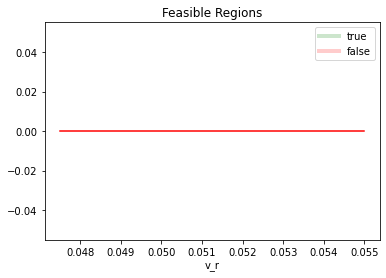

In [36]:
scenario2 = Scenario2(duration=20, query_threshold=hospital_capacity, step_size=2)
results = scenario2.analyze_intervention_vaccination([-0.05, 0.1])


# Scenario 1
- Inputs: Simulator, 
- Query: Will Intervention keep hospitalizations below 3000?
- Intervention 1: Dec 1 - Mar 1, 5% decrease in transmission
- Intervention 2: Jan 1 - Mar 1, X% decrease required?

# Open Issues
1. Infected > Hospitalized, how is Hospitalized defined?
    - Assume that H = I * HR, HR = hospitalization rate, maybe synthesize HR
2. Initial Conditions?  
    - From Data.  

# Goals
1. Synthesize (X, Start Intervention)
2. Synthesize (HR, gamma, End of Intervention)
3. Models: CHIME, BUCKY, CHIME SVIIR

# Analysis:
1. Intervention 1 works (yes/no), Intervention 2 (range of X that works, single variable synthesis)
2. Compute a metric: I1: sum of differences with threshold, I2: uniform grid evaluation of sum of differences.
3. Additional Parameters: HR, Start of Intervention, 
4. Sensitivity Analysis: What values of infection rate will the intervention work or not.  

# Operations:
- evaluate point
- project onto subset of dimensions
- project after assigning dimensions 
- Evaluate metric over remaining space

# Scneario 2
- Inputs:
    - Query: Rate of vaccination to keep cases under threshold over period of time
    - Result: Compute minimum vacc rate
- Parameters:
    - Vaccination rate
    - Age range (optional)
    - Age specific efficacy

# Scenario 3
- Identify indifference region wrt. parameters.
- Outside of indifference region are candidate parameters where one model is better.
- Generate two parameter spaces, identify symm diff, and evaluate metric over symm diff uniform grid.  Metric can be the fit to data.

In [ ]:
# Notes in this cell

# chime_bilayer_src = {
#     "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
#     "Win": [
#         {"arg": 1, "call": 1},
#         {"arg": 2, "call": 1},
#         {"arg": 2, "call": 2},
#     ],
#     "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
#     "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
#     "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
#     "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
# }

# measurements = {
#     "S" : [{"variable": "I"}],
#     "O" : [{"observable" : "H"}],
#     "D" : [{"parameter": "hr"}],
#     "Din": [{"variable": 1, "parameter": 1}],
#     "Dout": [{"parameter": 1, "observable": 1}]
# }

# chime_bilayer = Bilayer.from_json(chime_bilayer_src, measurements)


# chime_bilayer_src2 = {
#     "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
#     "Win": [
#         {"arg": 1, "call": 1},
#         {"arg": 2, "call": 1},
#         {"arg": 2, "call": 2},
#     ],
#     "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
#     "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
#     "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
#     "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
# }

# measurements2 = {
#     "S" : [{"variable": "I"}],
#     "O" : [{"observable" : "H"}],
#     "D" : [{"parameter": "hr"}],
#     "Din": [{"variable": 1, "parameter": 1}],
#     "Dout": [{"parameter": 1, "observable": 1}]
# }
# chime_bilayer2 = Bilayer.from_json(chime_bilayer_src2, measurements2)

# fail = Bilayer.from_json({}, {})
# HybridAutomaton(
#     [Node(chime_bilayer, QueryLE(chime_bilayer, "I", 1000)), Node(chime_bilayer2, QueryLE(chime_bilayer, "I", 1000)), Node(fail, None)],
#     [Jump(chime_bilayer, Guard(QueryLE(chime_bilayer, "days", 10)),chime_bilayer2)]
#     )

# chime_bilayer = Bilayer.from_json(chime_bilayer_src, measurements)
# chime_bilayer.to_dot()
